In [1]:
import numpy as np
from typing import Tuple
import matplotlib.pyplot as plt

SIGNAL_COUNT = 7
CLASS_COUNT = 4
NUM_FOLFDS = 10

clean_dataset = np.loadtxt("wifi_db/clean_dataset.txt", delimiter="\t")
noisy_dataset = np.loadtxt("wifi_db/noisy_dataset.txt", delimiter=" ")

TEST_DATASET = clean_dataset

In [2]:
# decision_tree_learning

def all_same_label(dataset) -> bool:
    # check if all samples have the same label
    for i in range(len(dataset)):
        if dataset[i][SIGNAL_COUNT] != dataset[0][SIGNAL_COUNT]:
            return False    
    return True

def entropy(dataset) -> float:
    # H(D) = - Sum(P(X) * log2(P(X))) for each X in Classes

    if len(dataset) == 0:
        return 0.0
    
    entropy = 0.0
    counts = [0] * CLASS_COUNT

    for i in range(len(dataset)):
        class_index = int(dataset[i][SIGNAL_COUNT]) - 1
        counts[class_index] = counts[class_index] + 1

    for c in range(CLASS_COUNT):
        if counts[c] > 0:
            fraction = counts[c] / len(dataset)
            entropy -= fraction * np.log2(fraction)

    return entropy

def calculate_IG(full_dataset, l_dataset, r_dataset) -> float:
    # IG(D1, D2) = H(D) - H(D1, D2)
    # H(D1, D2) = (|D1|/|D|)H(D1) + (|D2|/|D|)H(D2)

    # H(D) and |D|
    full_entropy = entropy(full_dataset)
    full_length = len(full_dataset)

    # (|D1|/|D|) and (|D2|/|D|)
    if full_length > 0:
        l_fraction = len(l_dataset) / full_length
        r_fraction = len(r_dataset) / full_length
    else:
        l_fraction = 0.0
        r_fraction = 0.0

    # H(D1) and H(D2)
    l_entropy = entropy(l_dataset)
    r_entropy = entropy(r_dataset)

    # H(D1, D2)
    combined_entropy = l_fraction * l_entropy + r_fraction * r_entropy

    # return IG(D1, D2)
    return full_entropy - combined_entropy

def pick_split_value(dataset, attribute: int) -> Tuple[float, float]:
    # find the best value to split by
    highest_IG = 0.0
    best_value = None

    dataset = dataset[dataset[:, attribute].argsort()]

    prev_value = dataset[0][attribute]

    for i in range(1, len(dataset) - 1):
        if dataset[i][attribute] == prev_value:
            continue
        else: 
            prev_value = dataset[i][attribute]
        
        l_dataset = dataset[:i]
        r_dataset = dataset[i:]

        information_gain = calculate_IG(dataset, l_dataset, r_dataset)

        if information_gain > highest_IG:
            highest_IG = information_gain
            best_value = dataset[i][attribute]
    
    return (highest_IG, best_value)

def find_split(dataset):
    # find the best split

    if len(dataset) == 2:
        i = 0
        while dataset[0][i] == dataset[1][i]:
            i = i + 1
        # print("Splitting attribute " + str(i) + " at value " + str(max(dataset[0][i], dataset[1][i])))
        return (i, max(dataset[0][i], dataset[1][i]))
    
    best_attribute = 0
    best_value = None
    best_IG = 0.0

    for i in range(SIGNAL_COUNT):
        (information_gain, value) = pick_split_value(dataset, i)

        if value is not None and information_gain > best_IG:
            best_IG = information_gain
            best_attribute = i
            best_value = value

    if best_value is None:
        best_value = dataset[1][best_attribute]
    
    # print("Splitting attribute " + str(best_attribute) + " at value " + str(best_value))
    return (best_attribute, best_value)

def decision_tree_learning(dataset, depth) -> Tuple[dict, int]:
    # print("Depth: " + str(depth))
    if depth > 50:
        return ({"error": "error"}, depth)
    if all_same_label(dataset):
        # print("Value: " + str(dataset[0][SIGNAL_COUNT]))
        return ({"value": dataset[0][SIGNAL_COUNT]}, depth)
    else:
        (split_attribute, split_value) = find_split(dataset)

        l_dataset = dataset[dataset[:,split_attribute] < split_value]
        r_dataset = dataset[dataset[:,split_attribute] >= split_value]

        node = {"split_attribute": split_attribute, "split_value": split_value}

        l_branch, l_depth = decision_tree_learning(l_dataset, depth+1)
        r_branch, r_depth = decision_tree_learning(r_dataset, depth+1)

        node["l_branch"] = l_branch
        node["r_branch"] = r_branch

        return (node, max(l_depth, r_depth))

In [3]:
tree = decision_tree_learning(TEST_DATASET, 0)[0]

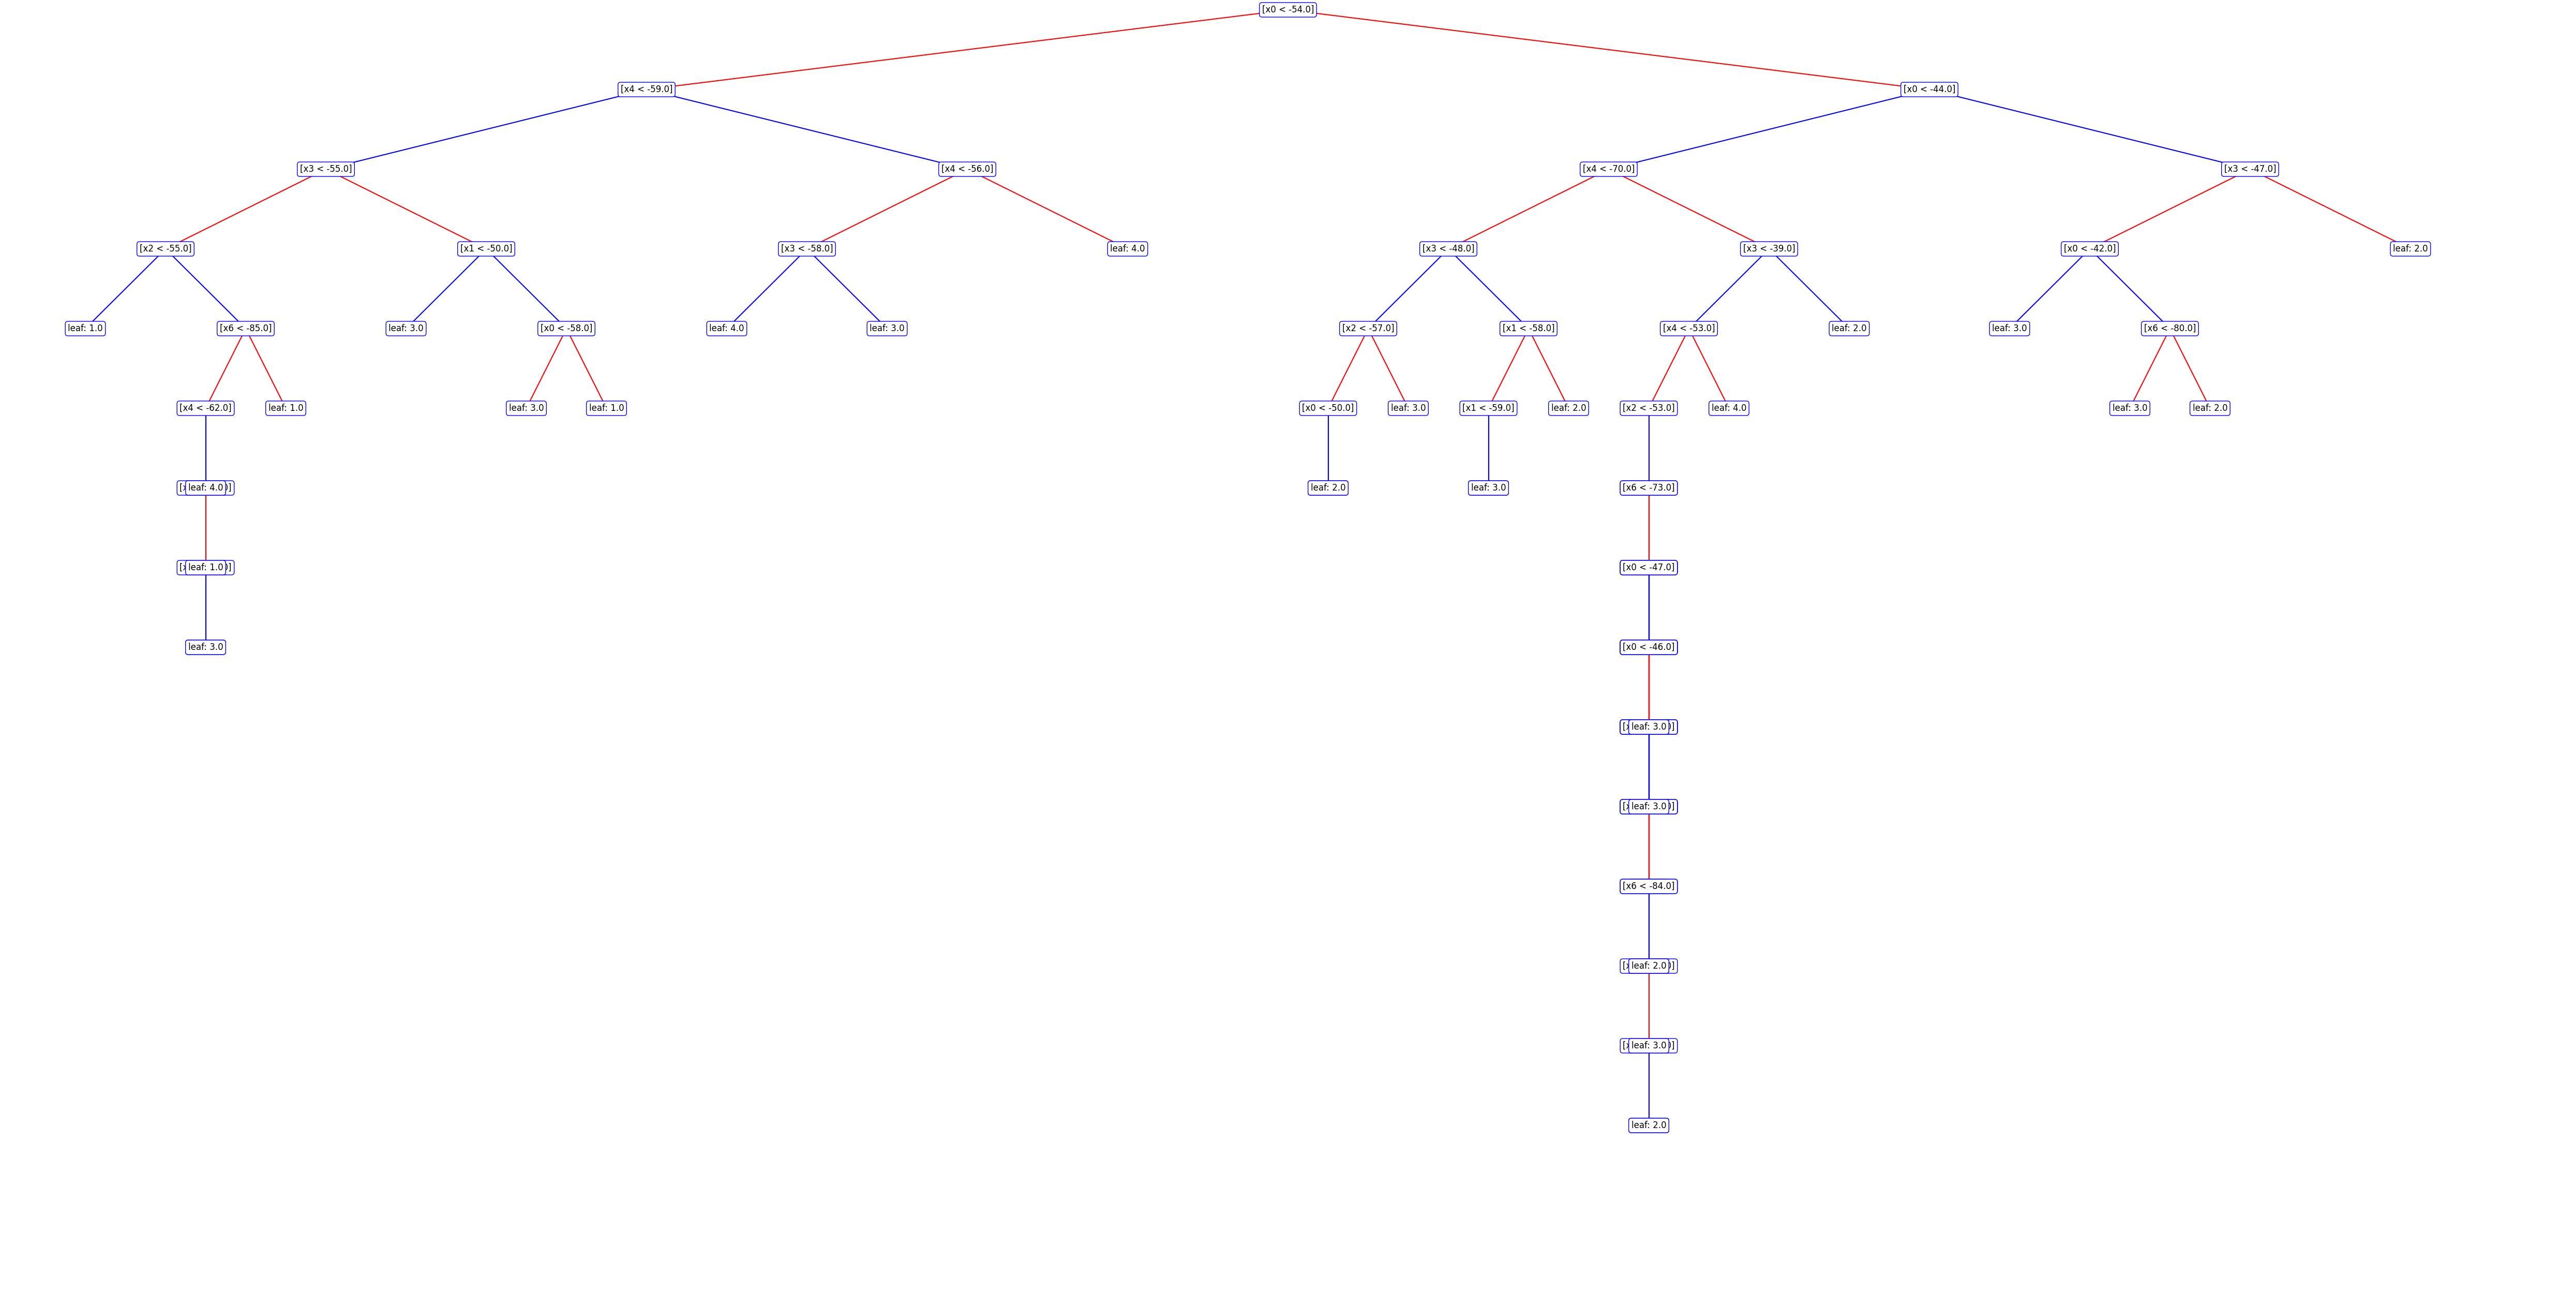

In [4]:
# tree visualiser

# adjust size here later to make it fit depending on the tree depth
fig_height = 2 ** 5
fig_width = 2 ** 6
fig, ax = plt.subplots(figsize=(fig_width, fig_height)) 
ax.set_xlim(0, fig_width)
ax.set_ylim(0, fig_height)
ax.axis("off")

def plot_node(node, x, y, child_offset, line_color):
    if line_color == "blue":
        line_color = "red"
    else:
        line_color = "blue"
    if "value" in node:
        ax.annotate(f"leaf: {node["value"]}", (x, y), fontsize=12, ha="center", va="center", bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="blue"))
    else:
        ax.annotate(f"[x{node['split_attribute']} < {node['split_value']}]", (x, y), fontsize=12, ha="center", va="center", bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="blue"))
        plot_node(node["l_branch"], x-child_offset, y-2, child_offset//2, line_color)
        plot_node(node["r_branch"], x+child_offset, y-2, child_offset//2, line_color)
        ax.add_line(plt.Line2D((x, x-child_offset), (y, y-2), c=line_color))
        ax.add_line(plt.Line2D((x, x+child_offset), (y, y-2), c=line_color))

plot_node(tree, fig_width//2, fig_height, fig_width//4,"blue")

In [5]:
# Metrics

def confusion(y_actual, y_prediction, class_labels):

    confusion = np.zeros((len(class_labels), len(class_labels)), dtype=np.int64)

    for i, label in enumerate(class_labels):
        indices = y_actual == label
        predictions = y_prediction[indices]

        (unique_labels, counts) = np.unique(predictions, return_counts=True)

        frequency_dict = dict(zip(unique_labels, counts))

        for j, class_label in enumerate(class_labels):
            confusion[i, j] = frequency_dict.get(class_label, 0)

    return confusion

def accuracy(confusion):
    if np.sum(confusion) > 0:
        return np.sum(np.diag(confusion)) / np.sum(confusion)
    return 0.0

def precision(confusion):
    precision = np.zeros((len(confusion),))
    for c in range(confusion.shape[0]):
        if np.sum(confusion[:, c]) > 0:
            precision[c] = confusion[c, c] / np.sum(confusion[:, c])

    return precision

def recall(confusion):
    recall = np.zeros((len(confusion),))
    for col in range(confusion.shape[0]):
        if np.sum(confusion[col, :]) > 0:
            recall[col] = confusion[col, col] / np.sum(confusion[col, :])

    return recall

def f1_score(precision, recall):
    f1 = np.zeros((len(precision),))
    for c, (p, r) in enumerate(zip(precision, recall)):
        if p + r > 0:
            f1[c] = 2 * p * r / (p + r)

    return f1

In [6]:
# Evaluation

def is_leaf(tree):
	return not "l_branch" in tree

def get_label(tree, values):
	if is_leaf(tree):
		return tree["value"]
	traverse_direction = (
		"l_branch" if values[tree["split_attribute"]] < tree["split_value"] else "r_branch"
	)
	return get_label(tree[traverse_direction], values)

def evaluate(test_db, tree):
	y_actual = np.array(test_db[:, -1])
	if len(y_actual) == 0:
		return 0.0
	y_prediction = np.array([get_label(tree, row) for row in test_db])
	return np.sum(y_actual == y_prediction) / len(y_actual)

In [7]:
def cross_validate(data, n_folds = NUM_FOLFDS):
    np.random.seed(42)
    np.random.shuffle(data)
    fold_size = len(data) // n_folds
    confusions = []
    accuracies = []
    recalls = []
    f1_scores = []
    precisions = []

    for i in range(n_folds):
        # print(f"Fold {i + 1}/{n_folds}")
        test_db = data[i * fold_size : (i + 1) * fold_size]
        train_db = np.concatenate([data[:i * fold_size], data[(i + 1) * fold_size:]])
        tree = decision_tree_learning(train_db, 0)[0]

        y_actual = np.array(test_db[:, -1])
        y_prediction = np.array([get_label(tree, row) for row in test_db])
        class_labels = np.unique(y_actual)

        confusions.append(confusion(y_actual, y_prediction, class_labels))
        accuracies.append(accuracy(confusions[-1]))
        recalls.append(recall(confusions[-1]))
        f1_scores.append(f1_score(precision(confusions[-1]), recalls[-1]))
        precisions.append(precision(confusions[-1]))

    return (np.mean(confusions, axis=0),
            np.mean(accuracies), 
            np.mean(precisions), 
            np.mean(recalls), 
            np.mean(f1_scores))

In [ ]:
# Metrics

confusion_mean, accuracy_mean, precision_mean, recall_mean, f1_score_mean = cross_validate(TEST_DATASET)
print(f'Mean Accuracy: {round(accuracy_mean, 10)}')
print(f'Mean Precision: {round(precision_mean, 10)}')
print(f'Mean Recall: {round(recall_mean, 10)}')
print(f'Mean F1 Score: {round(f1_score_mean, 10)}')
print(f'Conefusion Matrix:\n{confusion_mean}')